In [7]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [9]:
# load the CSV
all_data = pd.read_csv('../project/output/complete_cleaned_data.csv')

print(all_data)
all_cols = all_data.columns.tolist()
all_cols.remove('ClosePrice')
X_cols = all_cols
print(len(X_cols))

reduced_df = all_data.sample(frac=0.3, random_state=42)
print(reduced_df)

       ClosePrice  ViewYN  PoolPrivateYN   CloseDate   Latitude   Longitude  \
0        890000.0       1              0  2024-12-19  34.180411 -118.342020   
1       1138000.0       0              0  2024-12-31  32.574359 -117.023836   
2        681877.0       1              0  2024-12-23  33.725080 -117.222302   
3        900000.0       1              0  2024-12-30  34.203479 -118.643567   
4        862000.0       0              0  2024-12-24  34.460368 -118.490755   
...           ...     ...            ...         ...        ...         ...   
47854    265000.0       0              0  2025-05-23  33.701431 -117.199363   
47855   1350000.0       1              1  2025-05-07  34.115293 -116.319679   
47856    757000.0       1              0  2025-05-21  37.319615 -119.551230   
47857    510000.0       0              0  2025-05-01  33.943555 -118.285762   
47858    575000.0       0              0  2025-05-14  34.264846 -118.426665   

              UnparsedAddress PropertyType  LivingA

In [11]:
# Drop unwanted columns, including target!
X = reduced_df[X_cols]
y = reduced_df['ClosePrice']

X = X.drop(columns=['geometry'], errors='ignore')

# Fill missing values
X = X.fillna(0)

# Encode categorical columns ONCE only
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
if len(non_numeric_cols) > 0:
    print(f"Encoding categorical columns: {list(non_numeric_cols)}")
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

print("\nFinal feature matrix shape:", X.shape)

# Sanity check for NaNs
print("Any NaNs?", X.isnull().any().any())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define range of alphas to search over
# alphas_to_try = [0.1, 1000, 5000, 10000, 20000, 30000, 40000]
alphas_to_try = np.logspace(-2, 4, 10)
print("\nTrying alphas in range:", alphas_to_try)

# Train Lasso with cross-validation to choose best alpha
model = LassoCV(alphas=alphas_to_try, cv=5)
model.fit(X_train_scaled, y_train)

# Make predictions
y_test_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_test_pred)
mape1 = mape(y_test, y_test_pred) * 100
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


Encoding categorical columns: ['CloseDate', 'UnparsedAddress', 'PropertyType', 'CountyOrParish', 'ElementarySchool', 'PropertySubType', 'City', 'StateOrProvince', 'MiddleOrJuniorSchool', 'HighSchool', 'Levels', 'HighSchoolDistrict', 'PostalCode', 'CloseDate_Parsed', 'CloseDate_YearMonth']

Final feature matrix shape: (14358, 17818)
Any NaNs? False

Trying alphas in range: [1.00000000e-02 4.64158883e-02 2.15443469e-01 1.00000000e+00
 4.64158883e+00 2.15443469e+01 1.00000000e+02 4.64158883e+02
 2.15443469e+03 1.00000000e+04]


In [4]:
#To find top 10,000 best features for the Linear Regression Model ()

feature_names = X.columns.tolist()

print("Finding top 10,000 features using multiple methods...")
print("="*60)

# Method 1: Lasso coefficients (using your already trained model)
def get_top_lasso_features(model, feature_names, k=10):
    coefficients = np.abs(model.coef_)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_,
        'abs_coefficient': coefficients
    }).sort_values('abs_coefficient', ascending=False)
    
    # Filter out features with zero coefficients (Lasso sets many to exactly zero)
    non_zero_features = feature_importance[feature_importance['abs_coefficient'] > 0]
    
    print(f"Top {k} features from Lasso regression:")
    print("="*50)
    for i, (idx, row) in enumerate(non_zero_features.head(k).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<40} | Coef: {row['coefficient']:>10.4f}")
    
    return non_zero_features.head(k)['feature'].tolist()

# Method 2: Random Forest Feature Importance (quick and reliable)
def get_top_rf_features(X_train_scaled, y_train, feature_names, k=10):
    from sklearn.ensemble import RandomForestRegressor
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop {k} features from Random Forest:")
    print("="*50)
    for i, (idx, row) in enumerate(feature_importance.head(k).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<40} | Importance: {row['importance']:>10.4f}")
    
    return feature_importance.head(k)['feature'].tolist()

# Method 3: Statistical F-test
def get_top_statistical_features(X_train_scaled, y_train, feature_names, k=10):
    from sklearn.feature_selection import SelectKBest, f_regression
    
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X_train_scaled, y_train)
    
    # Get scores for all features
    scores = selector.scores_
    feature_scores = pd.DataFrame({
        'feature': feature_names,
        'f_score': scores
    }).sort_values('f_score', ascending=False)
    
    print(f"\nTop {k} features from F-test:")
    print("="*50)
    for i, (idx, row) in enumerate(feature_scores.head(k).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<40} | F-score: {row['f_score']:>10.2f}")
    
    return feature_scores.head(k)['feature'].tolist()

# Apply all methods
top_lasso_features = get_top_lasso_features(model, feature_names, k=10000)
top_rf_features = get_top_rf_features(X_train_scaled, y_train, feature_names, k=10000)
top_stat_features = get_top_statistical_features(X_train_scaled, y_train, feature_names, k=10000)

# Find consensus features
from collections import Counter

all_methods = [top_lasso_features, top_rf_features, top_stat_features]
all_features_flat = [feature for method_features in all_methods for feature in method_features]
feature_counts = Counter(all_features_flat)

consensus_features = pd.DataFrame(list(feature_counts.items()), 
                                columns=['feature', 'method_count']).sort_values('method_count', ascending=False)

print(f"\nConsensus Top 10000 features (appearing in multiple methods):")
print("="*60)
# Only show first 20 for readability, but store all 10000
for i, (idx, row) in enumerate(consensus_features.head(20).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<40} | Appears in {row['method_count']} methods")
print(f"... (showing first 20 out of top 10000 features)")

# Get the final top 10000 features
final_top_10000 = consensus_features.head(10000)['feature'].tolist()

print(f"\n" + "="*60)
print("FINAL TOP 10000 FEATURES:")
print("="*60)
print(f"Selected {len(final_top_10000)} features out of {len(feature_names)} total features")
# Only show first 20 for readability
for i, feature in enumerate(final_top_10000[:20], 1):
    print(f"{i:2d}. {feature}")
print(f"... (showing first 20 out of {len(final_top_10000)} selected features)")
    
# Optional: Test model performance with only these 10000 features
print(f"\n" + "="*60)
print("TESTING MODEL WITH ONLY TOP 10000 FEATURES:")
print("="*60)

# Create dataset with only top 10000 features
X_train_top10000 = X_train[final_top_10000]
X_test_top10000 = X_test[final_top_10000]

# Scale the selected features
scaler_top10000 = StandardScaler()
X_train_top10000_scaled = scaler_top10000.fit_transform(X_train_top10000)
X_test_top10000_scaled = scaler_top10000.transform(X_test_top10000)

# Train new model with only top 10000 features
model_top10000 = LassoCV(alphas=np.logspace(-2, 4, 10), cv=5)
model_top10000.fit(X_train_top10000_scaled, y_train)

# Make predictions
y_pred_top10000 = model_top10000.predict(X_test_top10000_scaled)

# Calculate metrics
r2_top10000 = r2_score(y_test, y_pred_top10000)
mape_top10000 = mape(y_test, y_pred_top10000) * 100
test_rmse10000 = np.sqrt(mean_squared_error(y_test, y_pred_top10000))
test_mse10000 = mean_squared_error(y_test, y_pred_top10000)
test_mae10000 = mean_absolute_error(y_test, y_pred_top10000)

print(f"Original model (all {len(feature_names)} features):")
print(f"  MSE: {test_mse:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  R²: {r2:.4f}")
print(f"  MAPE: {mape1:.2f}%")
print(f"\nModel with top 10000 features:")
print(f"  MSE: {test_mse10000:.2f}")
print(f"  RMSE: {test_rmse10000:.2f}")
print(f"  MAE: {test_mae10000:.2f}")
print(f"  R²: {r2_top10000:.4f}")
print(f"  MAPE: {mape_top10000:.2f}%")
print(f"\nFeature reduction: {len(feature_names)} → {len(final_top_10000)} features ({100*len(final_top_10000)/len(feature_names):.1f}% of original)")

if r2_top10000 >= r2 * 0.99:  # If R² is within 1% of original
    print("✅ Excellent performance maintained with feature selection!")
elif r2_top10000 >= r2 * 0.95:  # If R² is within 5% of original
    print("✅ Good performance maintained with feature selection!")
else:
    print("⚠️  Performance dropped. Consider using more features or different selection method.")

Finding top 10,000 features using multiple methods...
Top 10000 features from Lasso regression:
 1. LivingArea                               | Coef: 219613.9947
 2. CountyOrParish_Riverside                 | Coef: -130970.9062
 3. CountyOrParish_San Bernardino            | Coef: -99662.3540
 4. District__Manhattan Beach Unified School District | Coef: 76691.2696
 5. District__San Ramon Valley Unified School District | Coef: 71018.7644
 6. CountyOrParish_Orange                    | Coef: 67698.9939
 7. BathroomsTotalInteger                    | Coef: 67138.8338
 8. CountyOrParish_Others                    | Coef: -63068.4909
 9. PostalCode_92037                         | Coef: 60009.6471
10. PostalCode_92014                         | Coef: 57481.9058
11. PostalCode_92067                         | Coef: 54550.6828
12. CountyOrParish_Kern                      | Coef: -48007.8136
13. District__Fremont Unified School District | Coef: 46160.8723
14. PostalCode_92625                         |

In [20]:
import statsmodels.api as sm

X = X.astype(float)
y = y.astype(float)

X = sm.add_constant(X, has_constant='add')

print("Any object types?", X.select_dtypes(include=['object']).columns)
print("Final X dtypes:\n", X.dtypes)
print("Final y dtype:", y.dtypes)

print("Any NaNs in X?", X.isnull().any().any())
print("Any NaNs in y?", y.isnull().any())

model_1 = sm.OLS(y, X).fit()
print(model_1.summary())

Any object types? Index([], dtype='object')
Final X dtypes:
 const                          float64
const                          float64
const                          float64
ViewYN                         float64
PoolPrivateYN                  float64
                                ...   
CloseDate_YearMonth_2025-08    float64
CloseDate_YearMonth_2025-09    float64
CloseDate_YearMonth_2025-10    float64
CloseDate_YearMonth_2025-11    float64
CloseDate_YearMonth_2025-12    float64
Length: 17821, dtype: object
Final y dtype: float64
Any NaNs in X? False
Any NaNs in y? False
                            OLS Regression Results                            
Dep. Variable:             ClosePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.885e+13
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           1.84e-07
Time:                

Top 10 important features based on their p-value:


HighSchoolDistrict_Manhattan Unified                     1.491191e-08
PostalCode_90266                                         1.491191e-08
District__Manhattan Beach Unified School District        1.491191e-08
District__Newport-Mesa Unified School District           1.714057e-08
HighSchoolDistrict_Newport Mesa Unified                  1.714057e-08
LivingArea                                               1.746399e-08
PostalCode_92014                                         1.833603e-08
District__Santa Monica-Malibu Unified School District    1.977584e-08
PostalCode_92067                                         1.984233e-08
PostalCode_92037                                         2.230934e-08
dtype: float64


R² Score: 0.3043643370588378
RMSE: 588346.2591641096


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


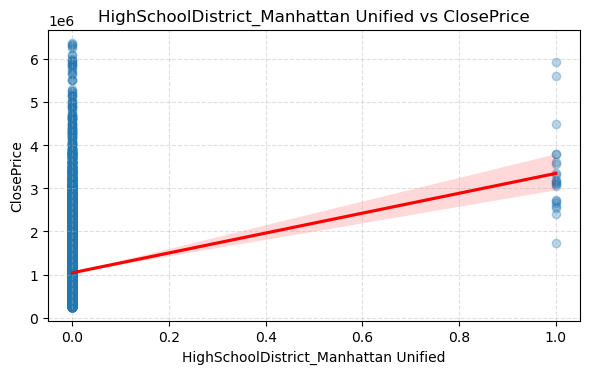

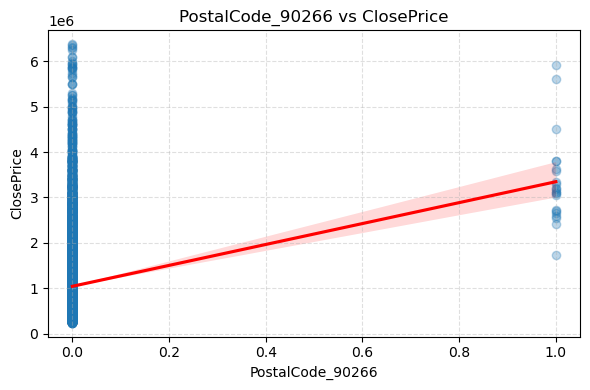

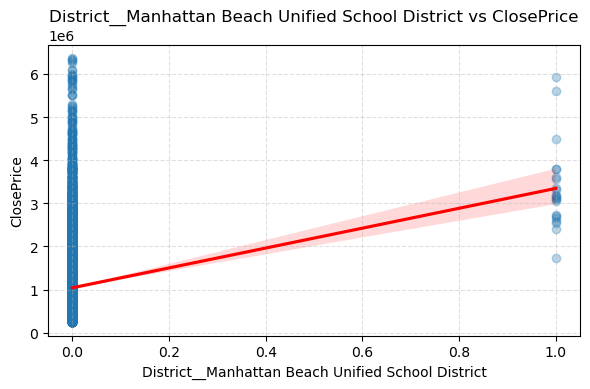

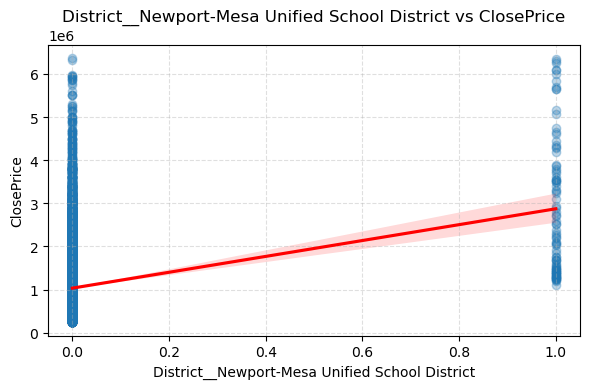

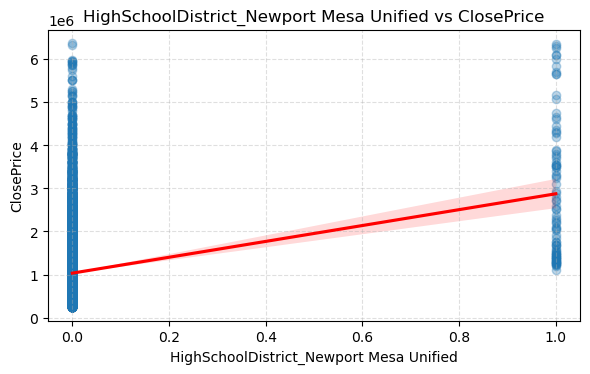

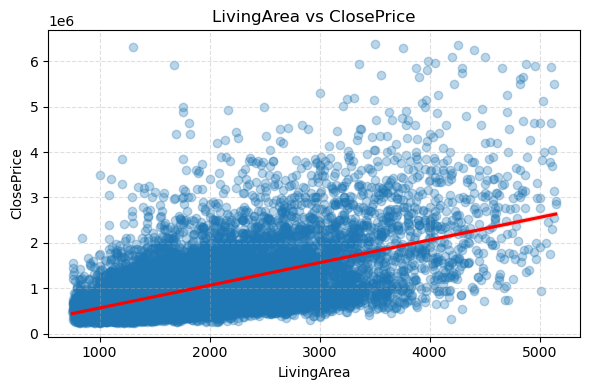

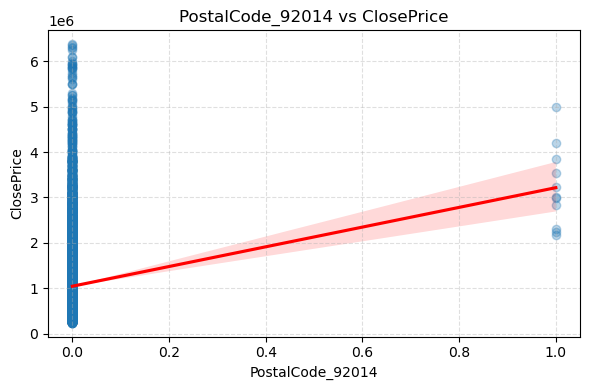

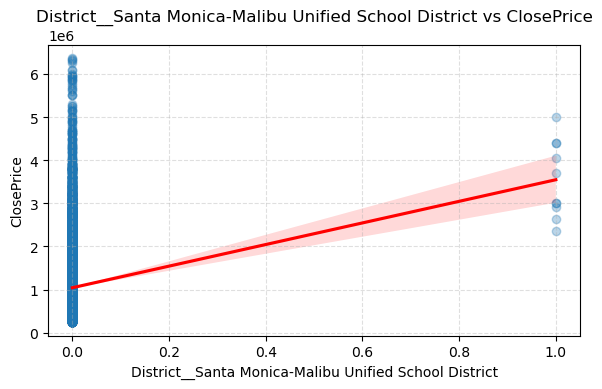

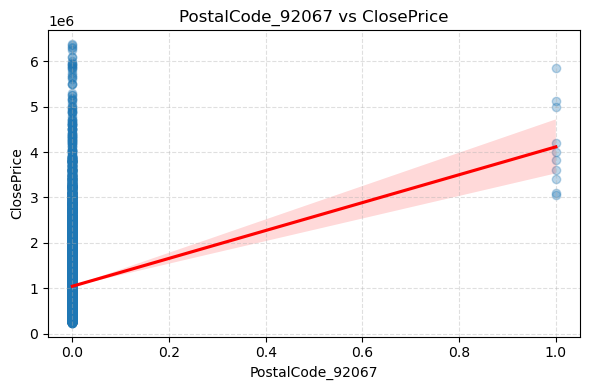

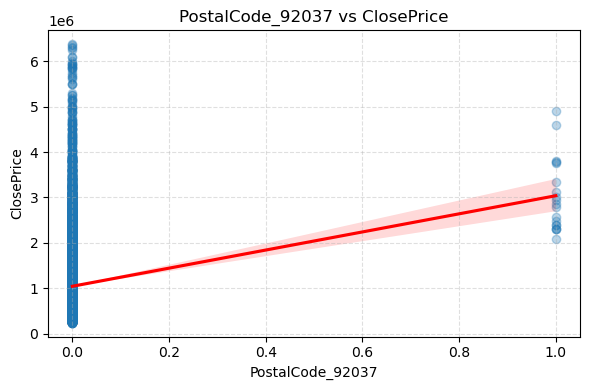

In [66]:
#For visualization plots
pvalues = model_1.pvalues.drop('const')
top_significant = pvalues.sort_values().head(10)
print("Top 10 important features based on their p-value:")
print("\n")
print(top_significant)
#final_top_10_features = final_top_10000[:10]
print("\n")
import seaborn as sns

top_significant_features = top_significant.index

X_top_significant = X[top_significant_features]
model_2 = LassoCV(cv=5, random_state=42)
model_2.fit(X_top_significant, y)


y_pred = model_2.predict(X_top_significant)

print("R² Score:", r2_score(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred, squared=False))


for feature in top_significant_features:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=X[feature], y=y, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
    plt.title(f"{feature} vs ClosePrice")
    plt.xlabel(feature)
    plt.ylabel("ClosePrice")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [68]:
joblib.dump(model_2, '../project/home-price-app/model.pkl')
print("✅ Model saved as model.pkl")

✅ Model saved as model.pkl
